In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


##Create a time series version of the PIT data: all indicators that existed in every year of data

In [ ]:
file_path = '/content/drive/MyDrive/Atlytics Hackathon/Data/Raw Data/Copy of 2007-2022-PIT-Counts-by-CoC (3).xlsx'
sheets_dict = pd.read_excel(file_path, sheet_name=None)

subset_sheets_dict = {}

#subset to only include Georgia
sheet_names = list(sheets_dict.keys())[:-1]

for sheet_name in sheet_names:
    original_df = sheets_dict[sheet_name]
    original_df = original_df.dropna(subset=['CoC Number'])
    subset_df = original_df[original_df['CoC Number'].str.startswith('GA')]
    subset_sheets_dict[sheet_name] = subset_df

#replace inconsistently named columns from 2022 with the names from past years for easier comparison

phrases_to_drop = ['Gender Questioning', 'Gender that is not Singularly Female or Male']

for sheet_name, df in subset_sheets_dict.items():
    if sheet_name == '2022':
        columns_to_drop = [col for col in df.columns if any(phrase in col for phrase in phrases_to_drop)]
        columns_dropped_count = len(columns_to_drop)
        df.drop(columns=columns_to_drop, inplace=True)

        print(f"{columns_dropped_count} columns dropped in sheet {sheet_name}")
    else:
        pass

#merge dataframes together on CoC Number
dfs_to_merge = []

for sheet_name, subset_df in subset_sheets_dict.items():
    subset_df = subset_df.set_index('CoC Number')
    dfs_to_merge.append(subset_df)

merged_df = dfs_to_merge[0]
for df in dfs_to_merge[1:]:
    merged_df = pd.merge(merged_df, df, left_index=True, right_index=True, how='outer')

merged_df = merged_df.reset_index()

#clean up merged df
cols_to_drop = [col for col in merged_df.columns if col.startswith('CoC Name') and col != 'CoC Name_x']
merged_df = merged_df.drop(columns=cols_to_drop)

#pivot to time series df - just keep the columns that have data for all years

time_series_cols = ['Overall Homeless', 'Sheltered ES Homeless', 'Sheltered TH Homeless', 'Sheltered Total Homeless',
                    'Unsheltered Homeless',	'Overall Homeless Individuals',	'Sheltered ES Homeless Individuals',
                    'Sheltered TH Homeless Individuals',	'Sheltered Total Homeless Individuals',	'Unsheltered Homeless Individuals',
                    'Overall Homeless People in Families',	'Sheltered ES Homeless People in Families',
                    'Sheltered TH Homeless People in Families', 'Sheltered Total Homeless People in Families',
                    'Unsheltered Homeless People in Families',	'Overall Homeless Family Households',
                    'Sheltered ES Homeless Family Households',	'Sheltered TH Homeless Family Households',
                    'Sheltered Total Homeless Family Households',	'Unsheltered Homeless Family Households',
                    'Overall Chronically Homeless Individuals',	'Sheltered Total Chronically Homeless Individuals',
                    'Unsheltered Chronically Homeless Individuals']

columns_to_keep = ['CoC Number'] + [col for col in merged_df.columns if col.split(', ')[0] in time_series_cols]
subset_df = merged_df[columns_to_keep]

melted_df = subset_df.melt(id_vars=['CoC Number'], var_name='Column', value_name='Values')

melted_df[['Designation', 'Year']] = melted_df['Column'].str.split(', ', expand=True)

pivot_df = melted_df.pivot_table(index=['CoC Number', 'Designation'], columns='Year', values='Values', aggfunc='first').reset_index()

pivot_df.reset_index(drop=True, inplace=True)
pivot_df.columns.name = None

#save time series df to google drive

csv_file_path = '/content/drive/MyDrive/Atlytics Hackathon/Data/PIT_Time_Series.csv'
pivot_df.to_csv(csv_file_path, index=False)

##Create a time series version of the PIT data: all demographic indicators that appeared in data since 2015

In [ ]:
#pivot to time series df - keep all demographic indicators

merged_df.columns = merged_df.columns.str.replace("Black, African American, or African", "Black African American or African")
merged_df.columns = merged_df.columns.str.replace("American Indian, Alaska Native, or Indigenous", "American Indian Alaska Native or Indigenous")

melted_df_dems = merged_df.melt(id_vars=['CoC Number'], var_name='Column', value_name='Values')

split_df_dems = melted_df_dems['Column'].str.split(', ', expand=True)
melted_df_dems['Designation'] = split_df_dems[0]
melted_df_dems['Year'] = split_df_dems[1]

melted_df_dems = melted_df_dems[split_df_dems[1].notna()]

melted_df_dems['Year'] = melted_df_dems['Year'].astype(int)

melted_df_dems = melted_df_dems[melted_df_dems['Year'] >= 2015]

pivot_df_dems = melted_df_dems.pivot_table(index=['CoC Number', 'Designation'], columns='Year', values='Values', aggfunc='first').reset_index()

pivot_df_dems.reset_index(drop=True, inplace=True)
pivot_df_dems.columns.name = None

csv_file_path = '/content/drive/MyDrive/Atlytics Hackathon/Data/PIT_Time_Series_Demographics_Since2015_v2.csv'
pivot_df_dems.to_csv(csv_file_path, index=False)

##Create time series dataframe with HIC data

In [ ]:
#HIC Counts by CoC
file_path = '/content/drive/MyDrive/Atlytics Hackathon/Data/Copy of 2007-2022-HIC-Counts-by-CoC (2).xlsx'
sheets_dict2 = pd.read_excel(file_path, sheet_name=None)

#subset to only include GA
sheet_names2 = list(sheets_dict2.keys())[:-1]
subset_sheets_dict2 = {}

for sheet_name in sheet_names2:
    original_df_hic = sheets_dict2[sheet_name]

    original_df_hic.rename(columns={col: "CoC Number" if col == "CoC" else col for col in original_df.columns}, inplace=True)

    original_df_hic = original_df_hic.dropna(subset=[col for col in original_df.columns if col.startswith('CoC Number')])

    subset_df_hic = original_df_hic[original_df_hic['CoC Number'].str.startswith('GA')]
    subset_sheets_dict2[sheet_name] = subset_df_hic


dfs_to_merge_hic = []

for sheet_name, subset_df_hic in subset_sheets_dict2.items():
    year = int(sheet_name)
    subset_df_hic = subset_df_hic.set_index('CoC Number')

    subset_df_hic.columns = [f"{col}, {year}" for col in subset_df_hic.columns]

    dfs_to_merge_hic.append(subset_df_hic)

merged_df_hic = dfs_to_merge_hic[0]
for df_hic in dfs_to_merge_hic[1:]:
    merged_df_hic = pd.merge(merged_df_hic, df_hic, left_index=True, right_index=True, how='outer')

merged_df_hic.reset_index(drop=False, inplace=True)

#pivot to time series df - keep all demographic indicators

merged_df_hic.columns = merged_df_hic.columns.str.replace("(ES, TH, SH)", "ES TH SH")

melted_df_hic = merged_df_hic.melt(id_vars=['CoC Number'], var_name='Column', value_name='Values')

split_df_hic = melted_df_hic['Column'].str.split(', ', expand=True)
melted_df_hic['Designation'] = split_df_hic[0]
melted_df_hic['Year'] = split_df_hic[1]

melted_df_hic = melted_df_hic[split_df[1].notna()]

melted_df_hic['Year'] = melted_df_hic['Year'].astype(int)

melted_df_hic = melted_df_hic[melted_df_hic['Year'] >= 2015]


pivot_df_hic = melted_df_hic.pivot_table(index=['CoC Number', 'Designation'], columns='Year', values='Values', aggfunc='first').reset_index()

pivot_df_hic.reset_index(drop=True, inplace=True)
pivot_df_hic.columns.name = None

#save time series to csv
csv_file_path = '/content/drive/MyDrive/Atlytics Hackathon/Data/HIC_Time_Series.csv'
pivot_df_hic.to_csv(csv_file_path, index=False)

##Visually investigate change in homeless trends over time since 2007

In [ ]:
#read in PIT time series data - all data since 2007
file_path = '/content/drive/MyDrive/Atlytics Hackathon/Data/PIT_Time_Series.csv'
pit = pd.read_csv(file_path)

In [ ]:
#create time series for each individual designation since 2007
atlanta = pit[pit['CoC Number'] == 'GA-500']

In [ ]:
# Melt the DataFrame to reshape it into long format
melted_df = atlanta.melt(id_vars=['CoC Number', 'Designation'], var_name='Year', value_name='Value')
melted_df['Year'] = melted_df['Year'].astype(int)

,CoC Number,Designation,Year,Value
0,GA-500,Overall Chronically Homeless Individuals,2007,1196.0
1,GA-500,Overall Homeless,2007,6840.0
2,GA-500,Overall Homeless Family Households,2007,379.0
3,GA-500,Overall Homeless Individuals,2007,5622.0
4,GA-500,Overall Homeless People in Families,2007,1218.0


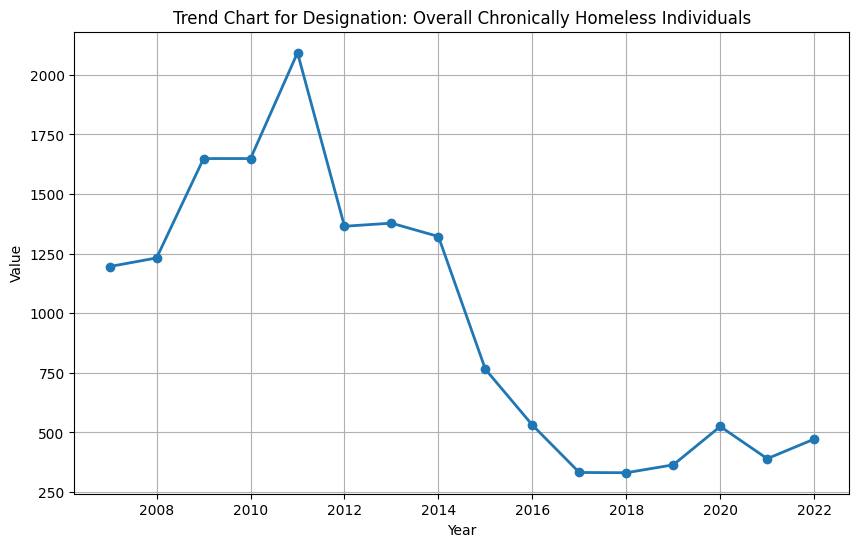

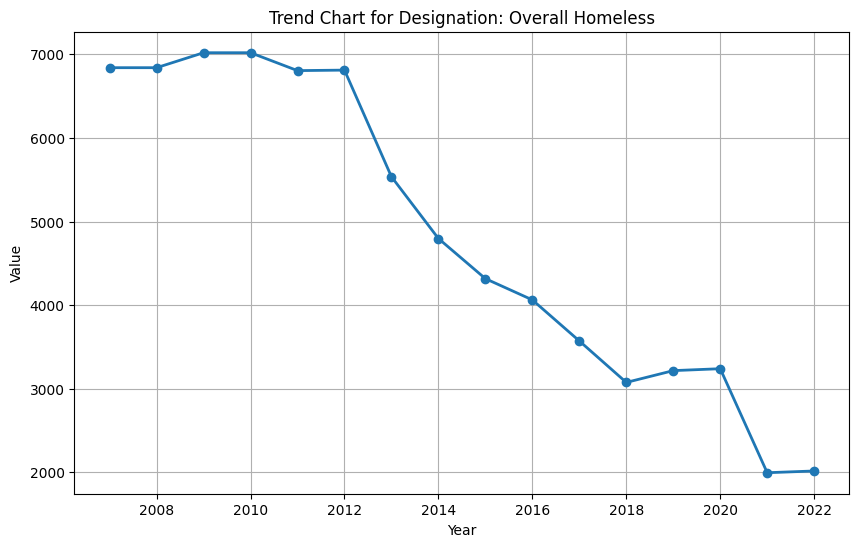

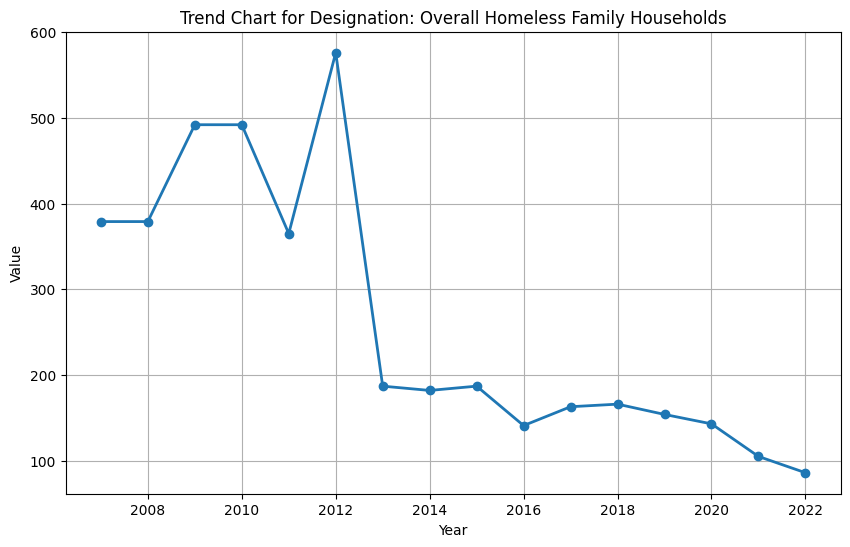

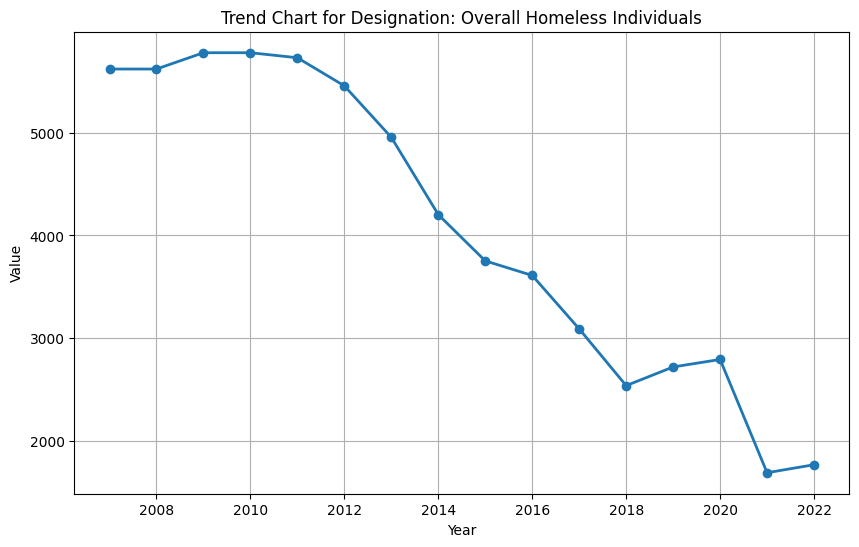

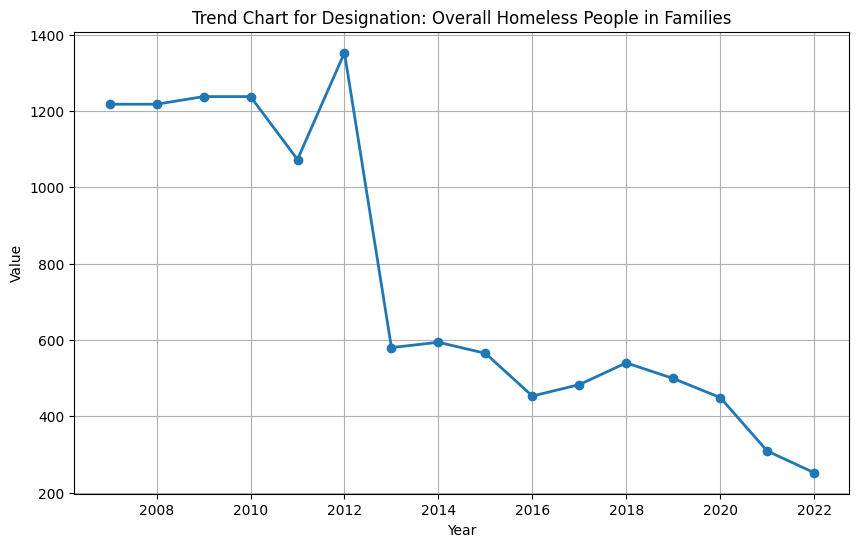

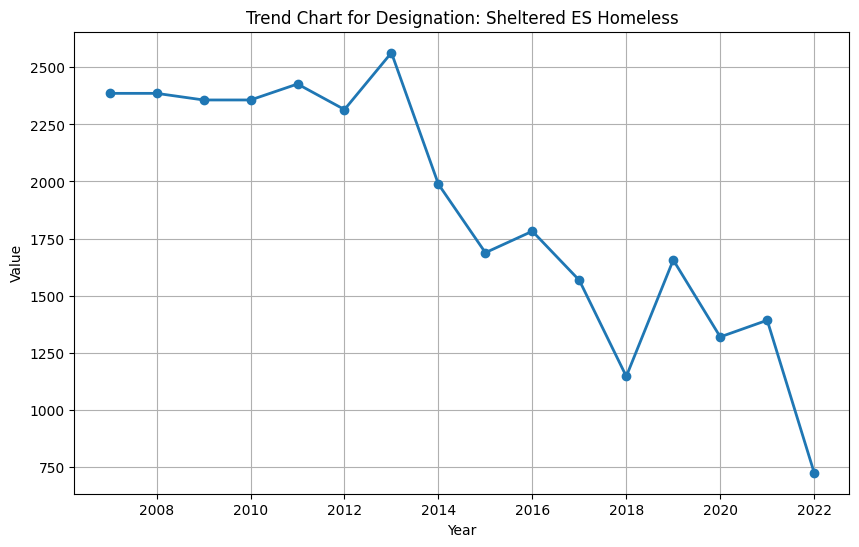

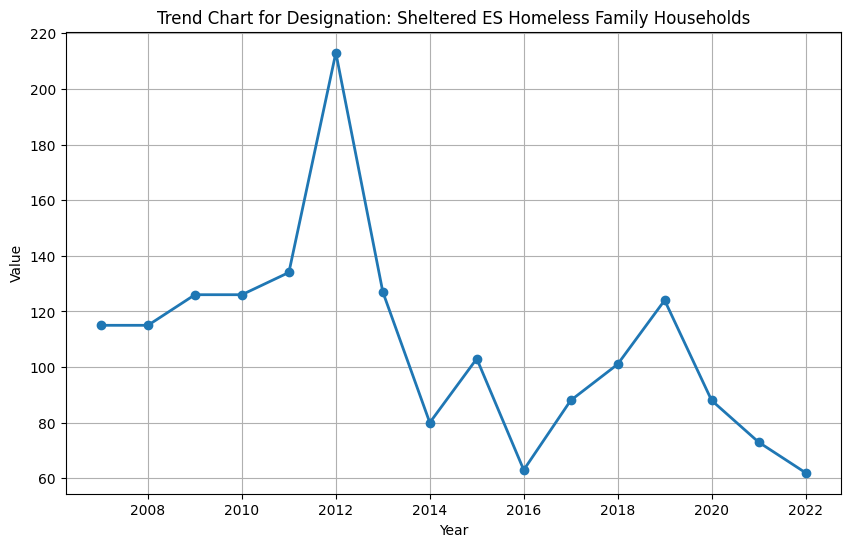

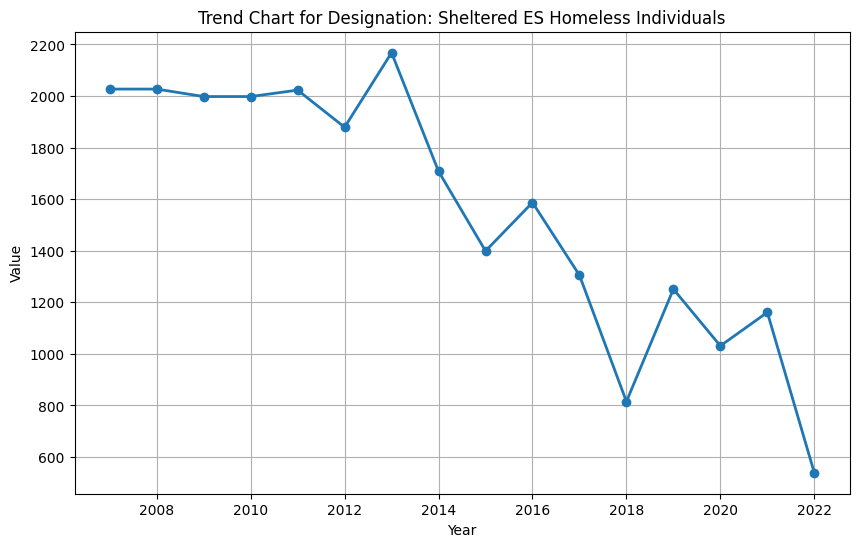

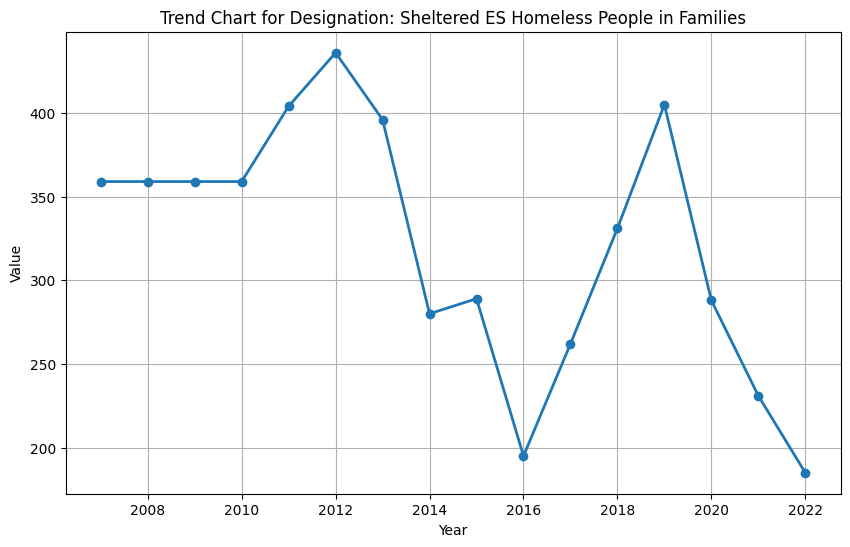

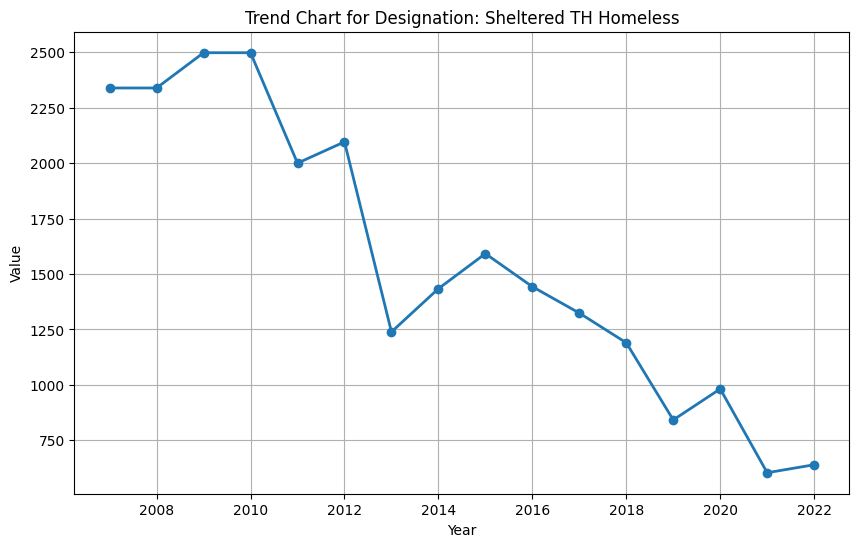

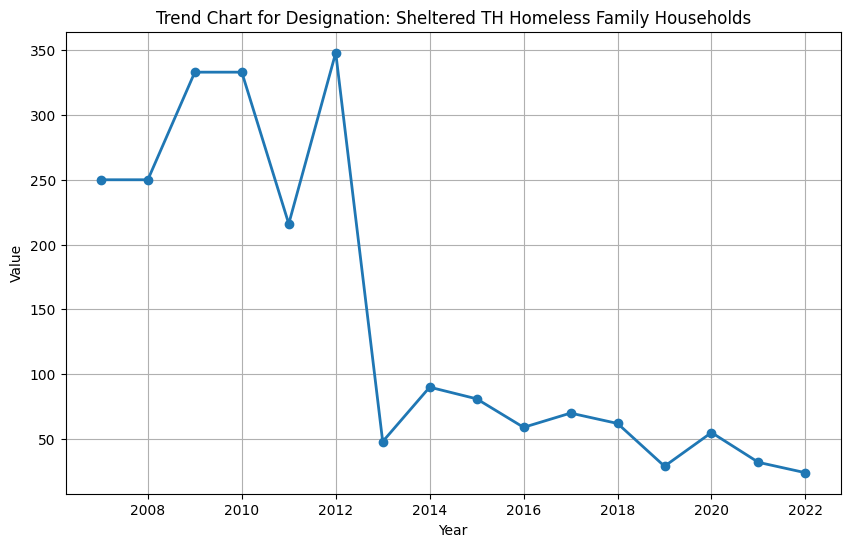

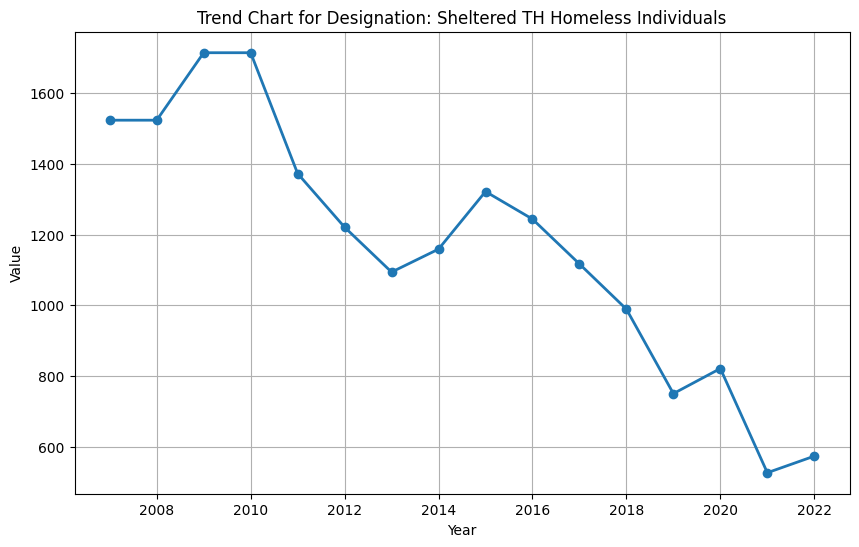

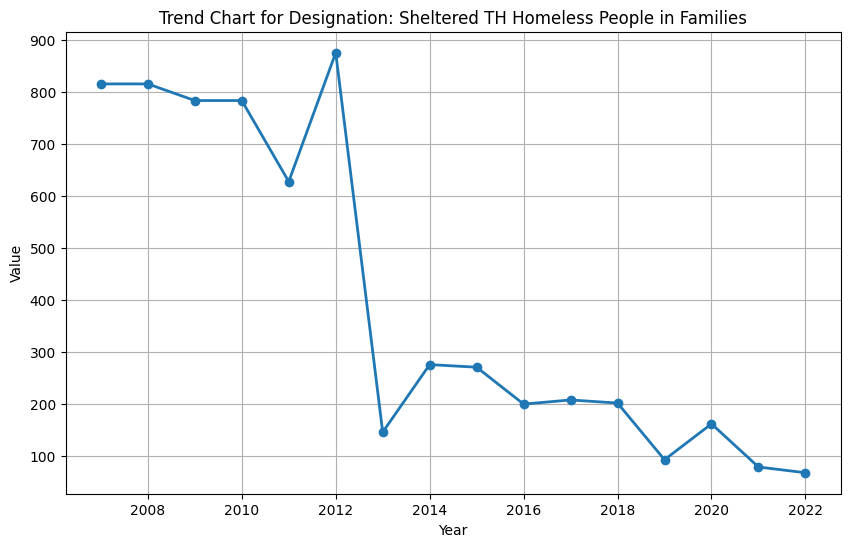

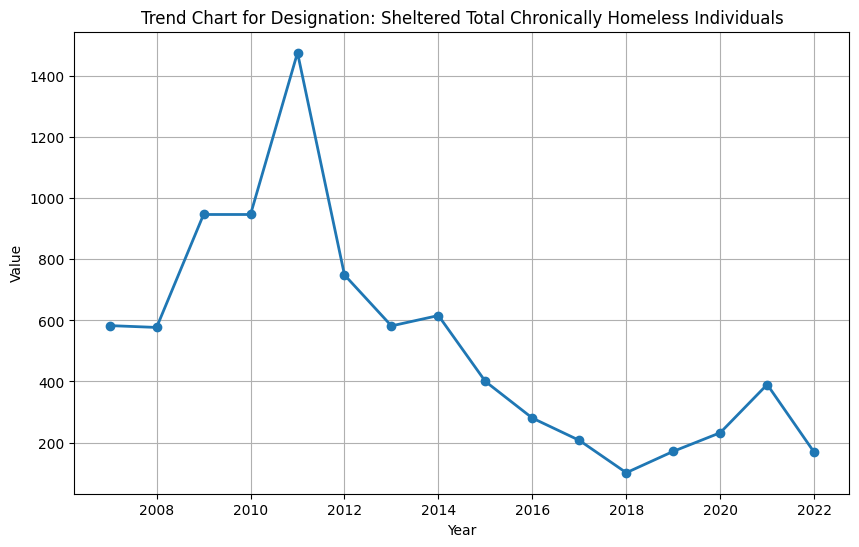

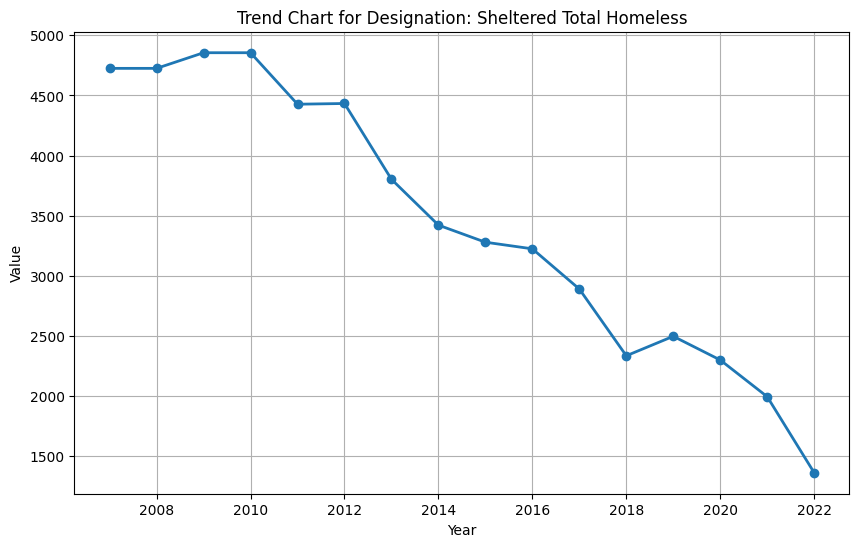

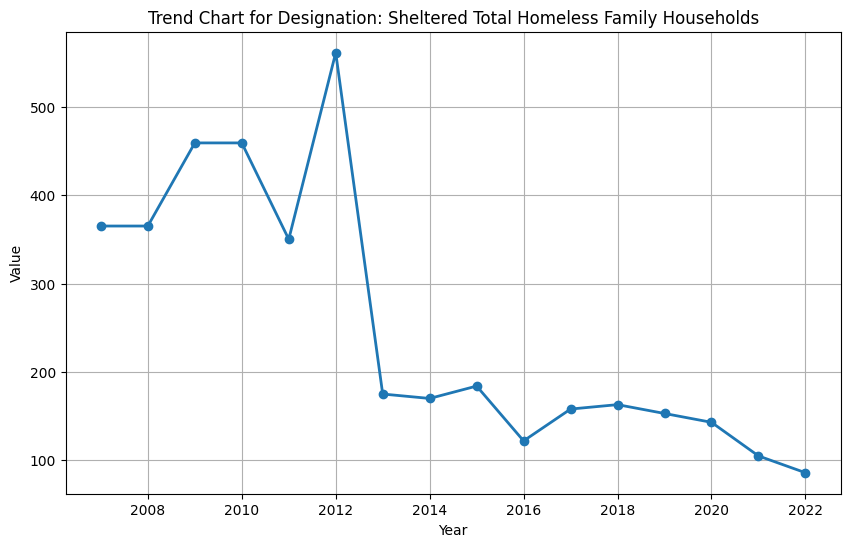

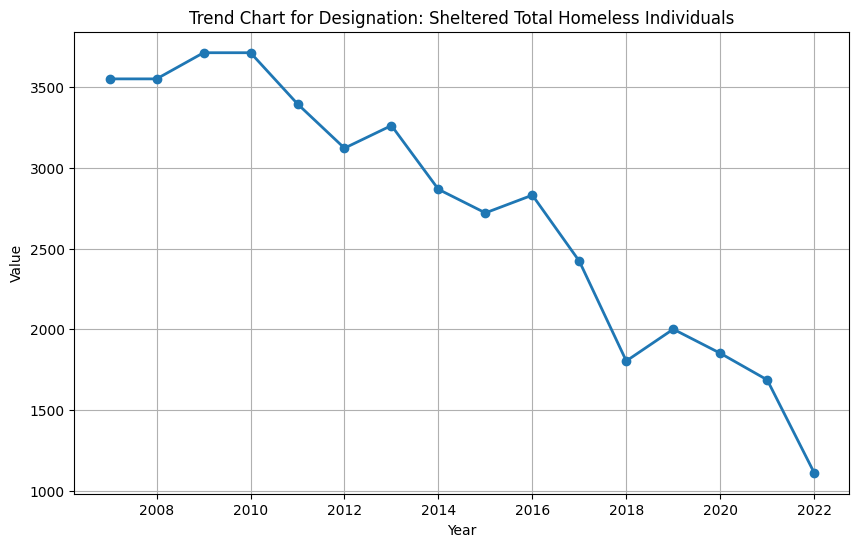

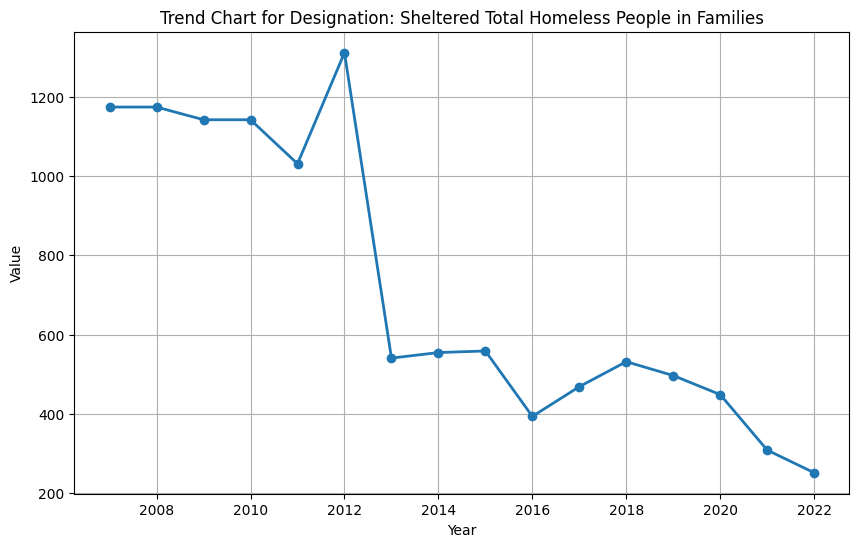

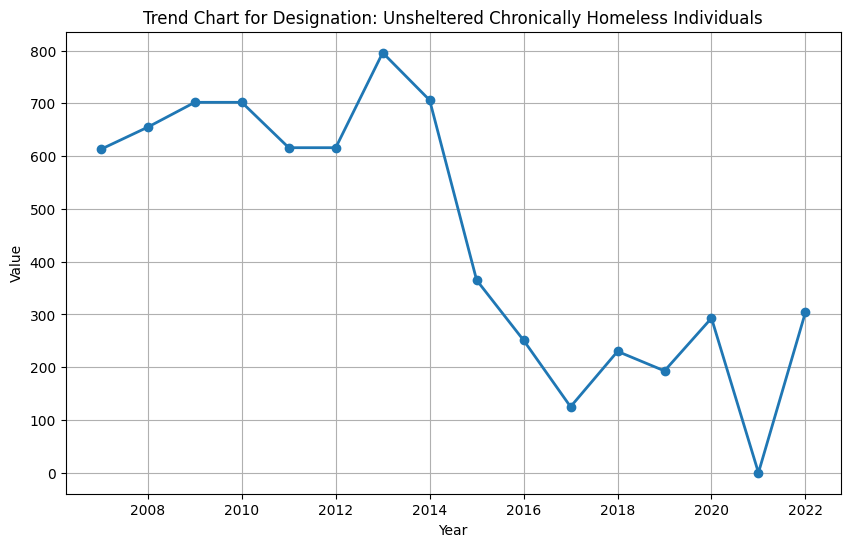

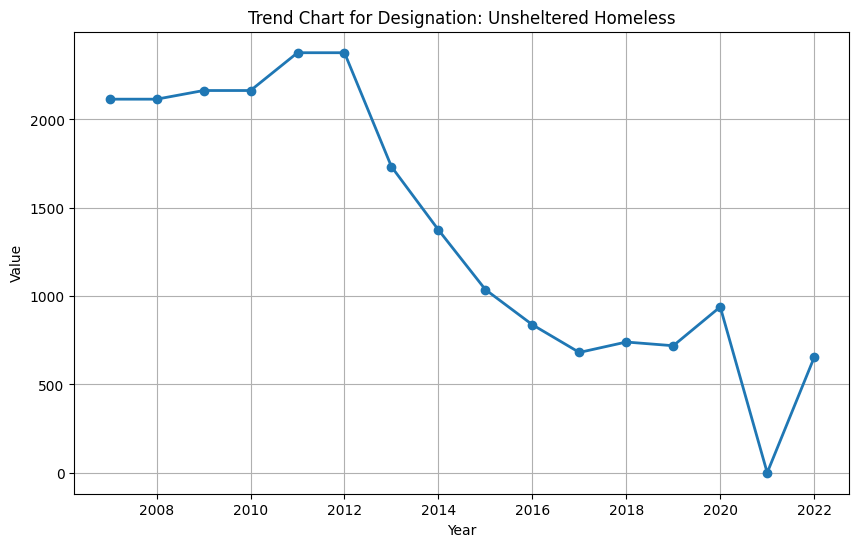

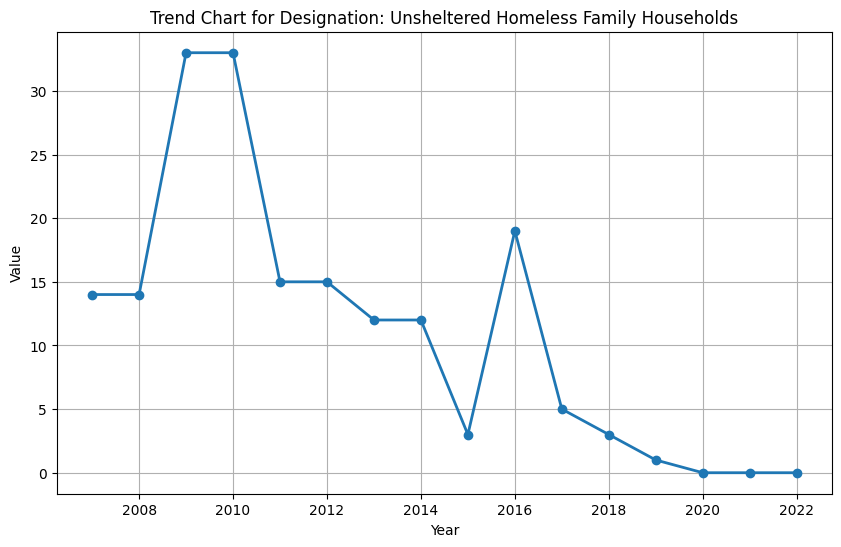

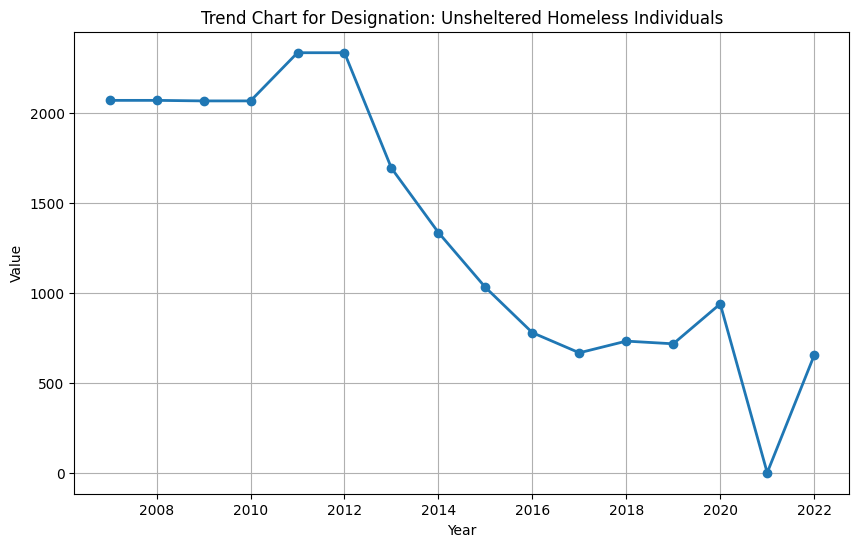

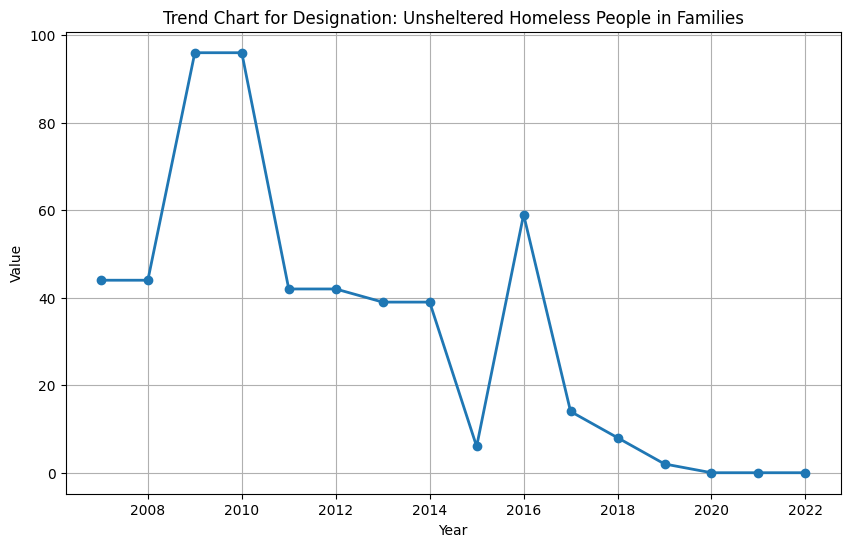

In [ ]:
unique_designations = melted_df['Designation'].unique()

for designation in unique_designations:
    designation_data = melted_df[melted_df['Designation'] == designation]

    plt.figure(figsize=(10, 6))
    plt.plot(designation_data['Year'], designation_data['Value'], marker='o', linestyle='-', linewidth=2)

    plt.title(f'Trend Chart for Designation: {designation}')
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()


In [ ]:
#check how percentages have changed over time
for year in melted_df['Year'].unique():
    overall_homeless_value = melted_df[
        (melted_df['Designation'] == 'Overall Homeless') & (melted_df['Year'] == year)
    ]['Value'].iloc[0]

    melted_df.loc[melted_df['Year'] == year, '%'] = (
        melted_df[melted_df['Year'] == year]['Value'] / overall_homeless_value * 100
    )

melted_df['%'] = melted_df['%'].round(2)

melted_df.head()

,CoC Number,Designation,Year,Value,%
0,GA-500,Overall Chronically Homeless Individuals,2007,1196.0,17.49
1,GA-500,Overall Homeless,2007,6840.0,100.00
2,GA-500,Overall Homeless Family Households,2007,379.0,5.54
3,GA-500,Overall Homeless Individuals,2007,5622.0,82.19
4,GA-500,Overall Homeless People in Families,2007,1218.0,17.81


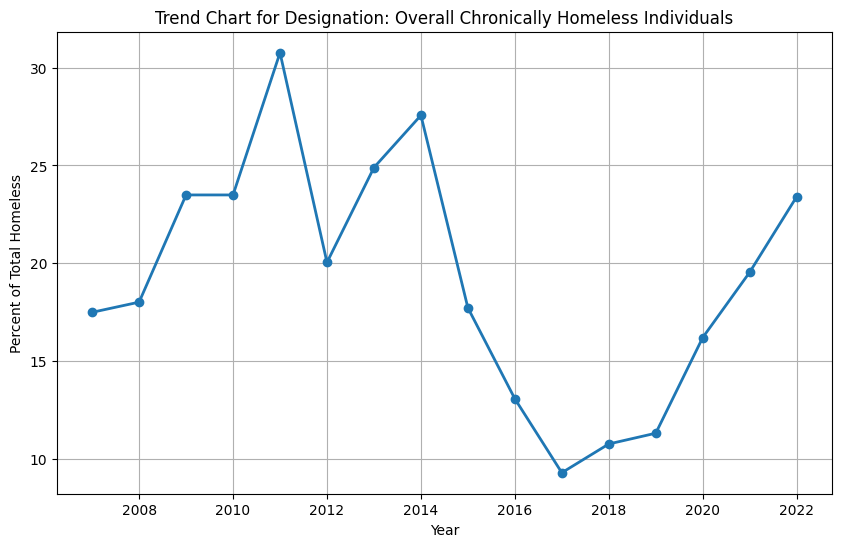

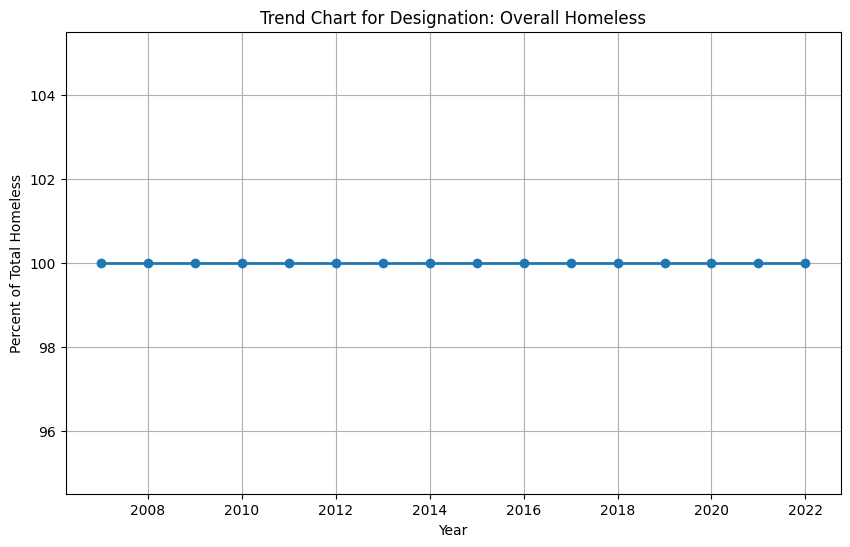

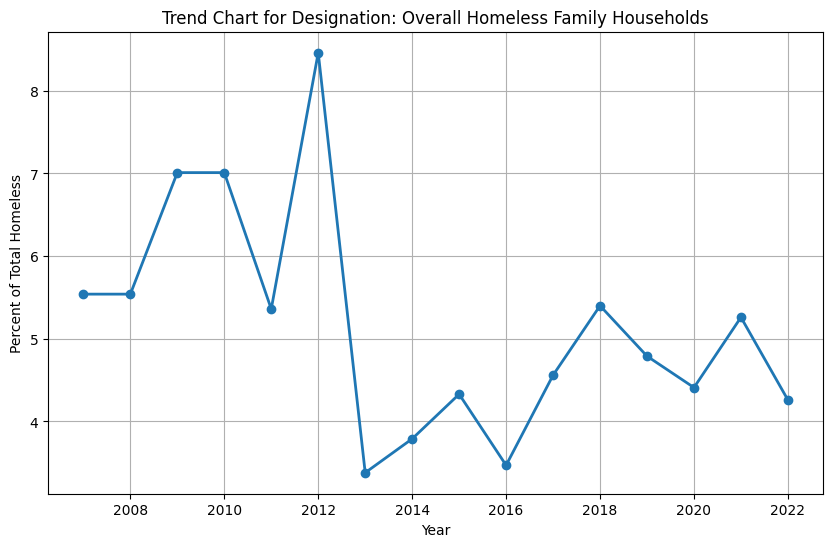

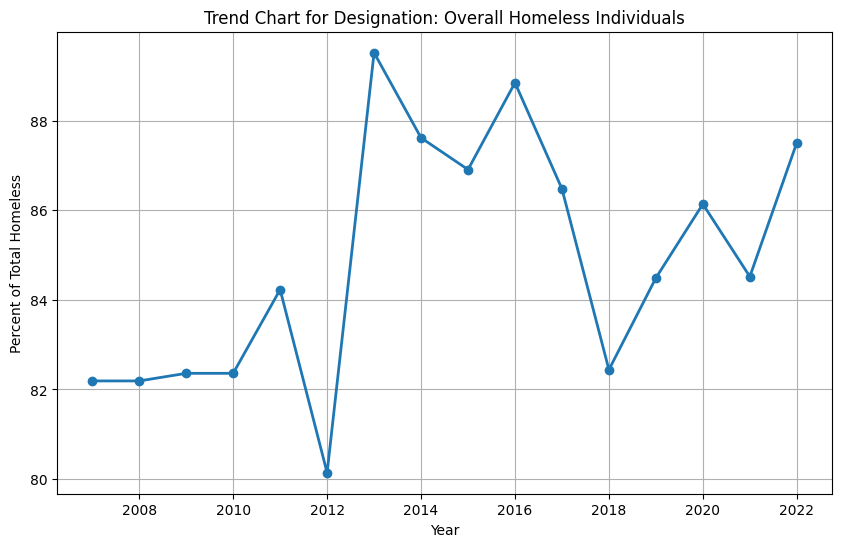

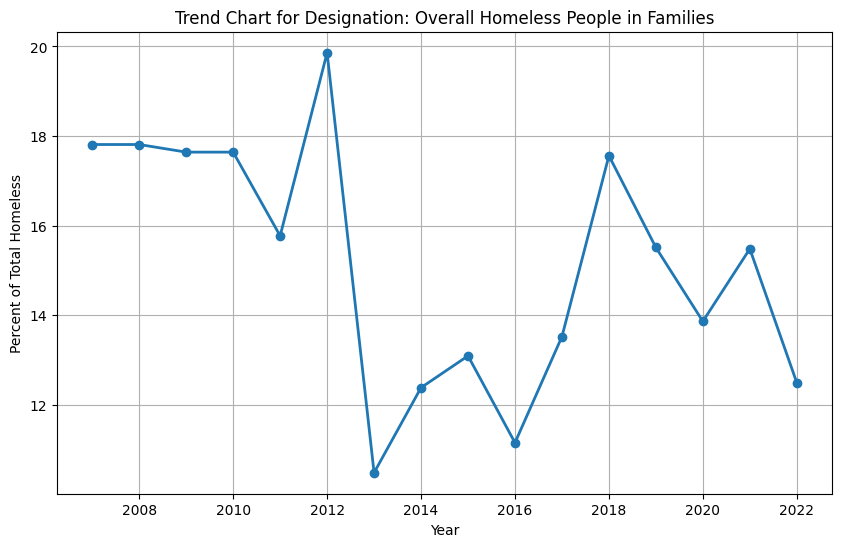

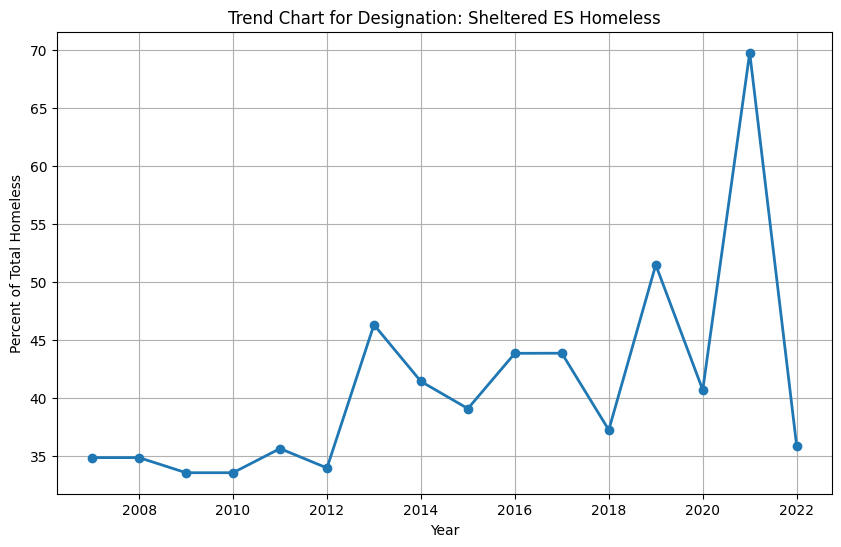

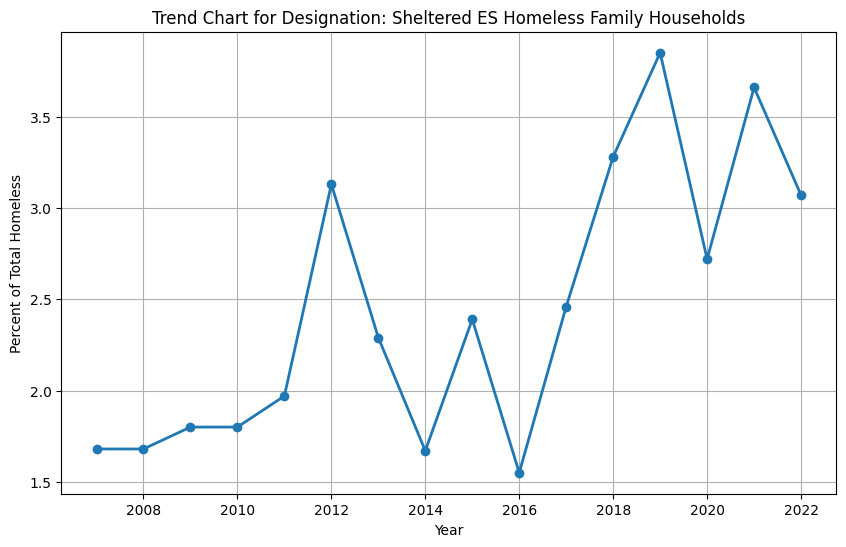

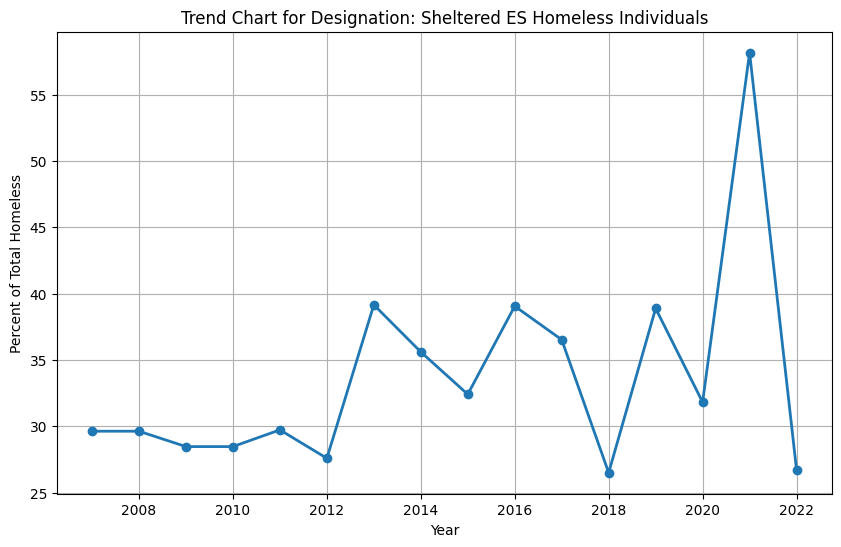

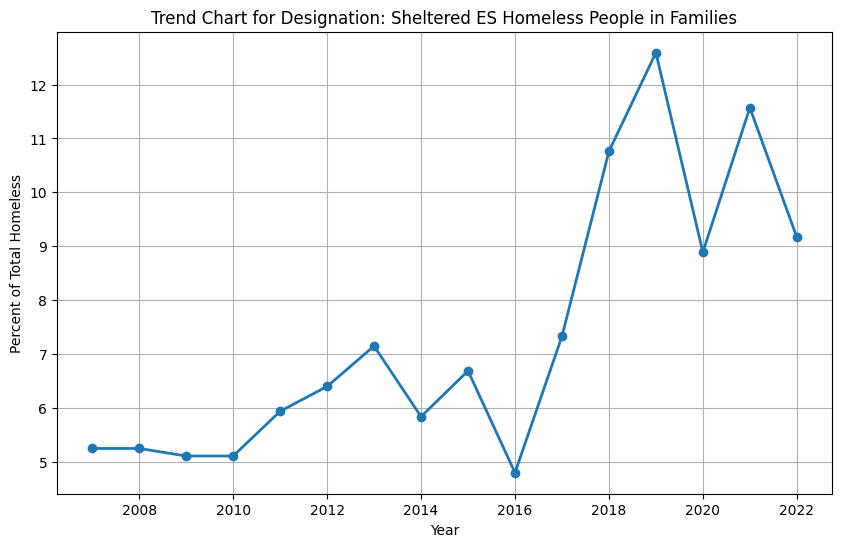

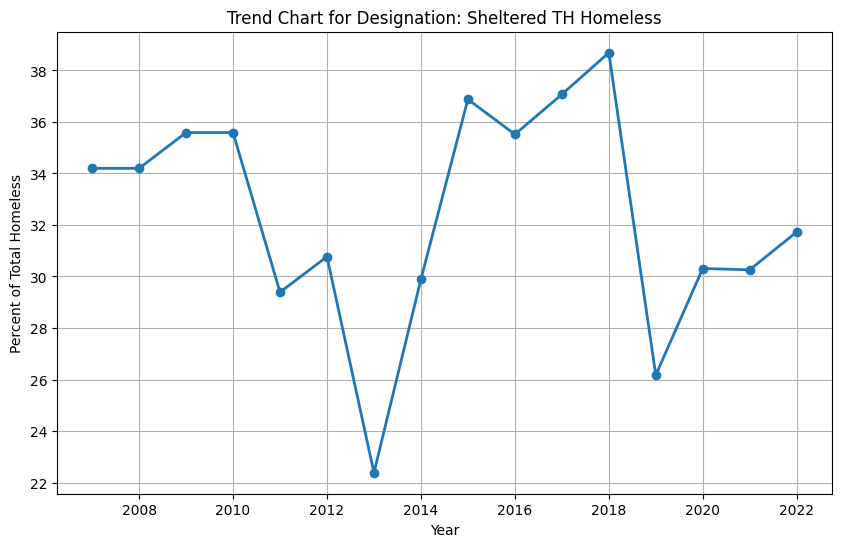

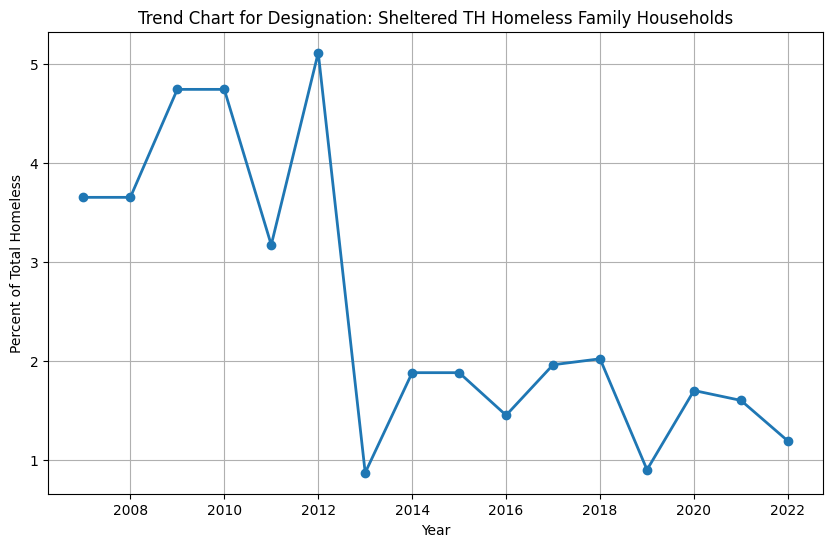

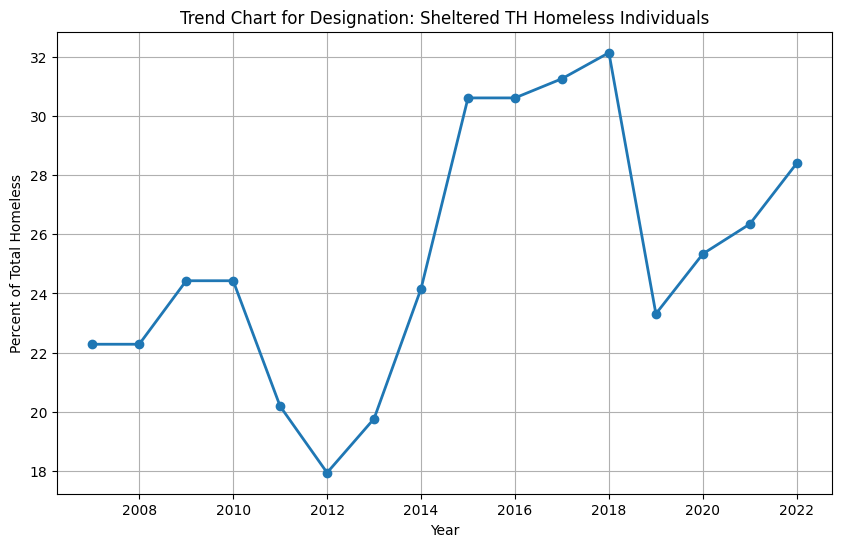

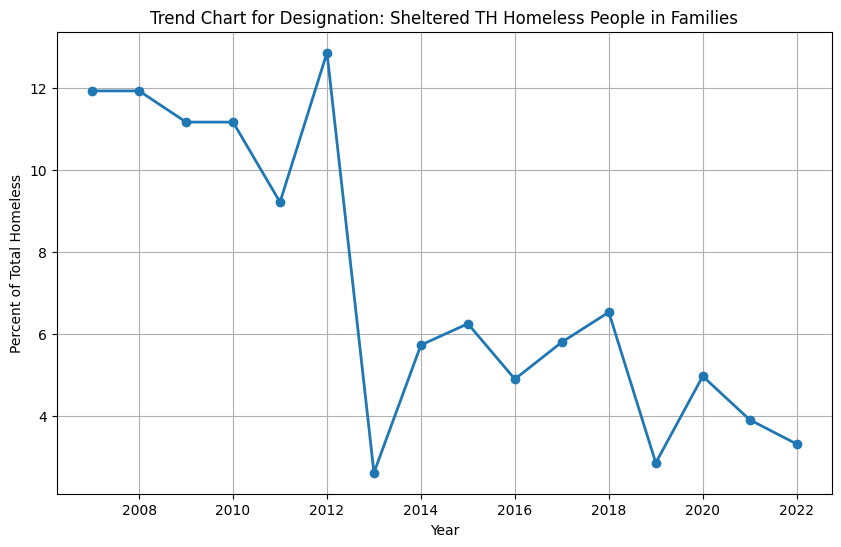

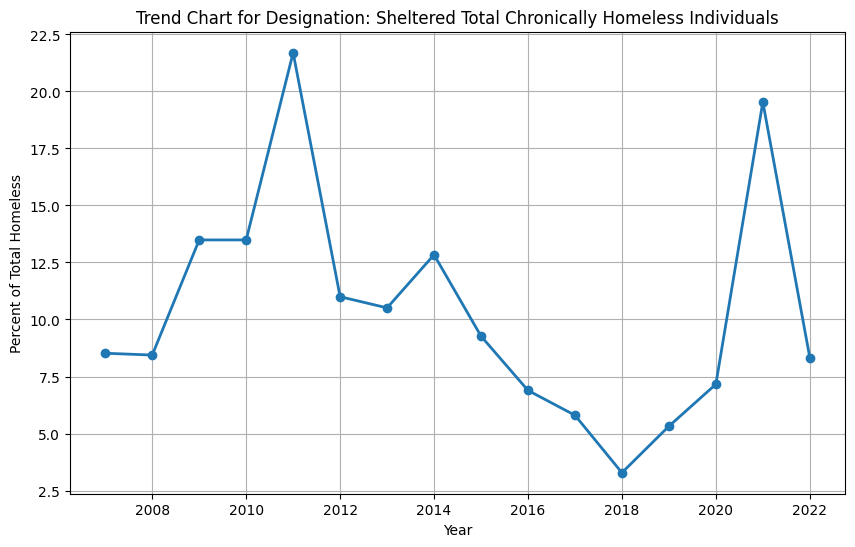

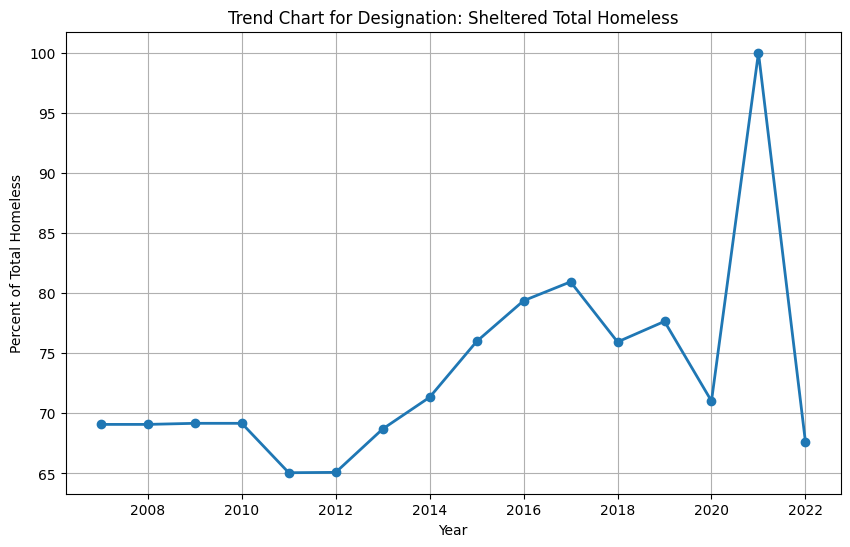

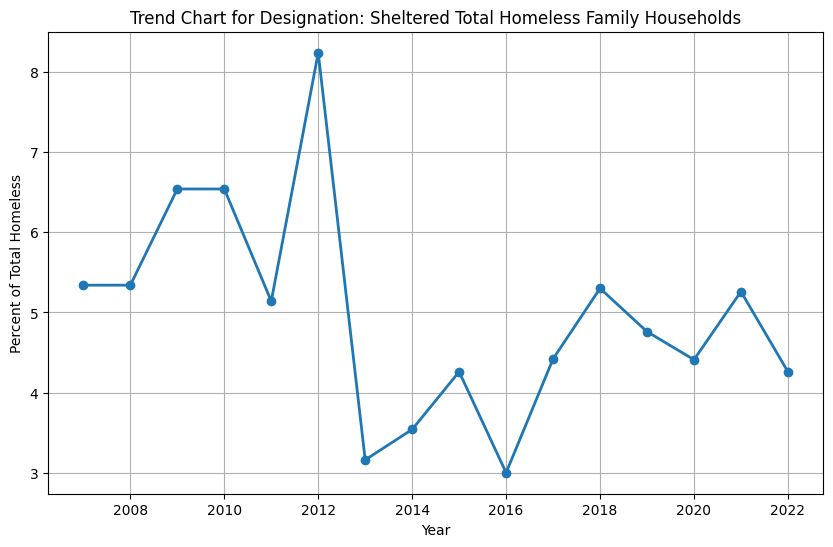

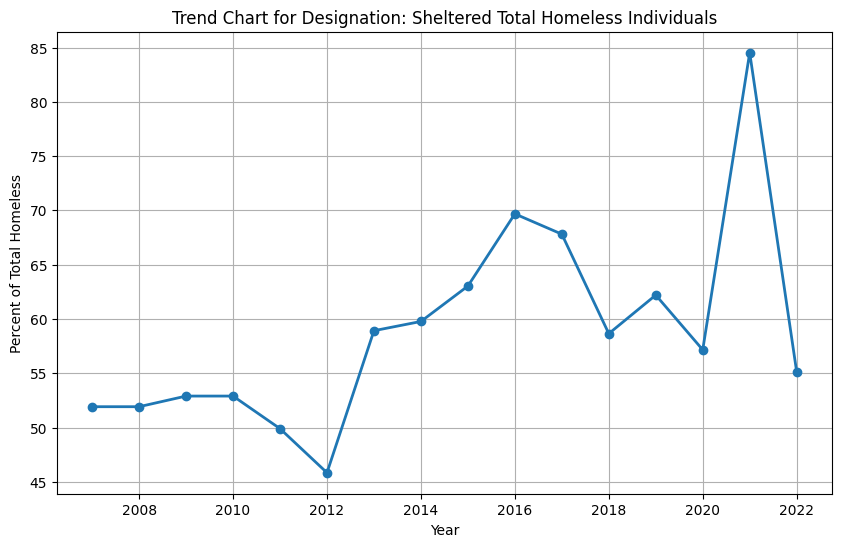

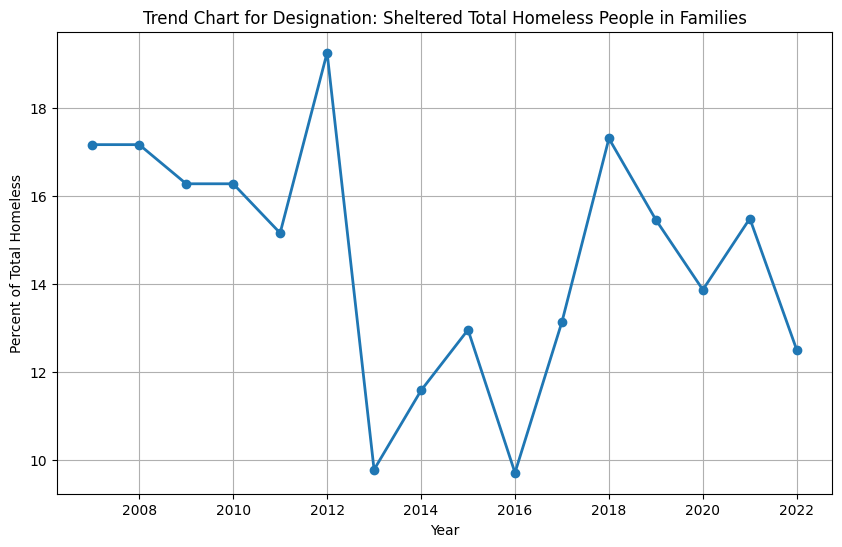

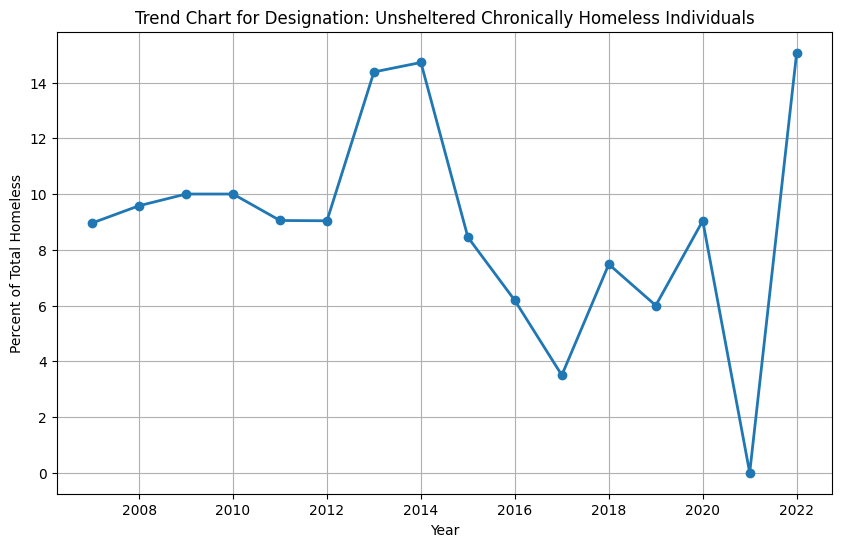

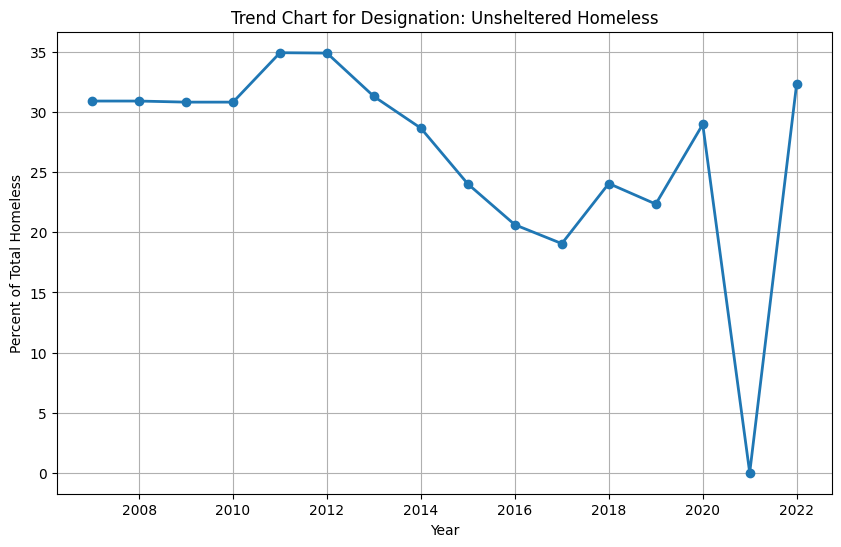

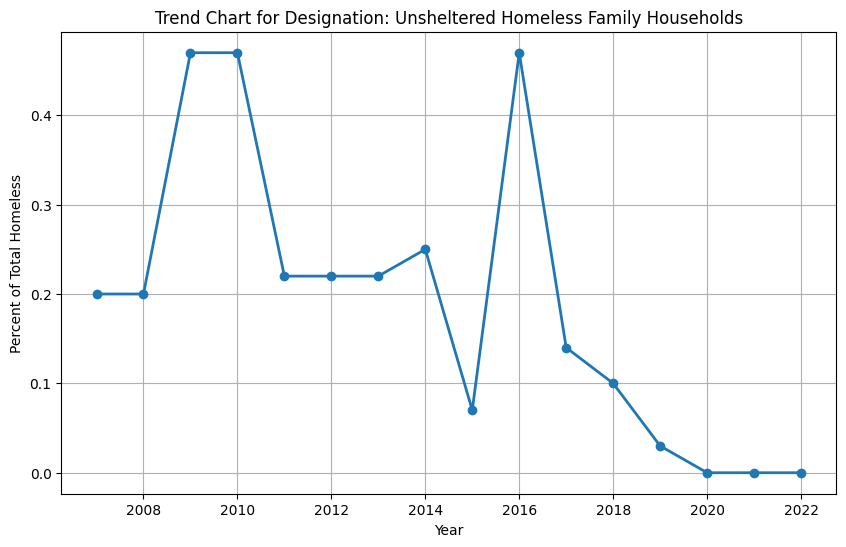

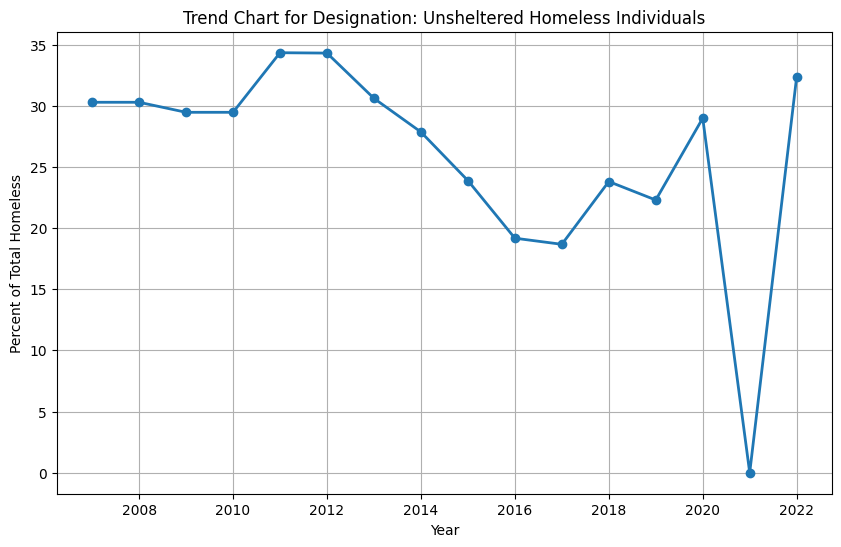

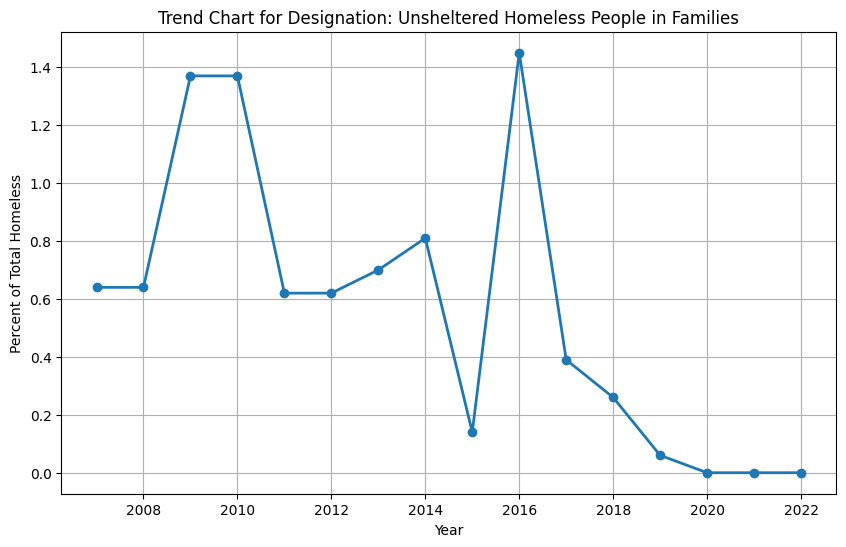

In [ ]:
unique_designations = melted_df['Designation'].unique()

for designation in unique_designations:
    designation_data = melted_df[melted_df['Designation'] == designation]

    plt.figure(figsize=(10, 6))
    plt.plot(designation_data['Year'], designation_data['%'], marker='o', linestyle='-', linewidth=2)

    plt.title(f'Trend Chart for Designation: {designation}')
    plt.xlabel('Year')
    plt.ylabel('Percent of Total Homeless')
    plt.grid(True)
    plt.show()

##Create filterable workbook for Tableau dashboard with PIT data

In [ ]:
#read in PIT time series data - data since 2015, focus on demographic differences
file_path = '/content/drive/MyDrive/Atlytics Hackathon/Data/PIT_Time_Series_Demographics_Since2015_v2.csv'
pit_dems = pd.read_csv(file_path)

In [ ]:
#add column for each classification:

  #overall, sheltered, unsheltered
  #age group
  #gender
  #hispanic/non hispanic
  #race
  #veteran
  #family unit
  #parenting youth
  #chronically homeless


#add housing group - sheltered, unsheltered or overall
def determine_housing_group(designation):
    if 'overall' in designation.lower():
        return 'overall'
    elif 'unsheltered' in designation.lower():
        return 'unsheltered'
    else:
        return 'sheltered'

pit_dems['Housing Group'] = pit_dems['Designation'].apply(determine_housing_group)

,CoC Number,Designation,2015,2016,2017,2018,2019,2020,2021,2022,Housing Group
0,GA-500,Overall Chronically Homeless,781.0,556.0,346.0,335.0,376.0,542.0,406.0,495.0,overall
1,GA-500,Overall Chronically Homeless Individuals,765.0,531.0,332.0,331.0,364.0,525.0,390.0,472.0,overall
2,GA-500,Overall Chronically Homeless People in Families,16.0,25.0,14.0,4.0,12.0,17.0,16.0,23.0,overall
3,GA-500,Overall Homeless,4317.0,4063.0,3572.0,3076.0,3217.0,3240.0,1996.0,2017.0,overall
4,GA-500,Overall Homeless - Age 18 to 24,216.0,375.0,217.0,187.0,187.0,176.0,131.0,132.0,overall


In [ ]:
#add age group

def determine_age_group(designation):
    if 'under 18' in designation.lower():
        return 'under 18'
    elif 'age 18 to 24' in designation.lower():
      return 'age 18 to 24'
    elif 'over 24' in designation.lower():
      return 'over 24'
    else:
      return None

pit_dems['age group'] = pit_dems['Designation'].apply(determine_age_group)

,CoC Number,Designation,2015,2016,2017,2018,2019,2020,2021,2022,Housing Group,age group
0,GA-500,Overall Chronically Homeless,781.0,556.0,346.0,335.0,376.0,542.0,406.0,495.0,overall,None
1,GA-500,Overall Chronically Homeless Individuals,765.0,531.0,332.0,331.0,364.0,525.0,390.0,472.0,overall,None
2,GA-500,Overall Chronically Homeless People in Families,16.0,25.0,14.0,4.0,12.0,17.0,16.0,23.0,overall,None
3,GA-500,Overall Homeless,4317.0,4063.0,3572.0,3076.0,3217.0,3240.0,1996.0,2017.0,overall,None
4,GA-500,Overall Homeless - Age 18 to 24,216.0,375.0,217.0,187.0,187.0,176.0,131.0,132.0,overall,age 18 to 24


In [ ]:
#add gender

def determine_gender(designation):
    if 'gender questioning' in designation.lower():
        return 'gender questioning'
    elif 'transgender' in designation.lower():
      return 'transgender'
    elif 'gender non-conforming' in designation.lower():
      return 'gender non-conforming'
    elif 'singularly' in designation.lower():
      return 'gender that is not singularly male or female'
    elif '- female' in designation.lower():
      return 'female'
    elif '- male' in designation.lower():
      return 'male'
    else:
      return None

pit_dems['gender'] = pit_dems['Designation'].apply(determine_gender)

,CoC Number,Designation,2015,2016,2017,2018,2019,2020,2021,2022,Housing Group,age group,gender
0,GA-500,Overall Chronically Homeless,781.0,556.0,346.0,335.0,376.0,542.0,406.0,495.0,overall,None,None
1,GA-500,Overall Chronically Homeless Individuals,765.0,531.0,332.0,331.0,364.0,525.0,390.0,472.0,overall,None,None
2,GA-500,Overall Chronically Homeless People in Families,16.0,25.0,14.0,4.0,12.0,17.0,16.0,23.0,overall,None,None
3,GA-500,Overall Homeless,4317.0,4063.0,3572.0,3076.0,3217.0,3240.0,1996.0,2017.0,overall,None,None
4,GA-500,Overall Homeless - Age 18 to 24,216.0,375.0,217.0,187.0,187.0,176.0,131.0,132.0,overall,age 18 to 24,None


In [ ]:
#add hispanic flag

def determine_hispanic(designation):
    if 'non-hispanic/non-latino' in designation.lower():
        return 'non-hispanic/non-latino'
    elif 'hispanic/latino' in designation.lower():
      return 'hispanic/latino'
    else:
      return None

pit_dems['hispanic'] = pit_dems['Designation'].apply(determine_hispanic)

,CoC Number,Designation,2015,2016,2017,2018,2019,2020,2021,2022,Housing Group,age group,gender,hispanic
0,GA-500,Overall Chronically Homeless,781.0,556.0,346.0,335.0,376.0,542.0,406.0,495.0,overall,None,None,None
1,GA-500,Overall Chronically Homeless Individuals,765.0,531.0,332.0,331.0,364.0,525.0,390.0,472.0,overall,None,None,None
2,GA-500,Overall Chronically Homeless People in Families,16.0,25.0,14.0,4.0,12.0,17.0,16.0,23.0,overall,None,None,None
3,GA-500,Overall Homeless,4317.0,4063.0,3572.0,3076.0,3217.0,3240.0,1996.0,2017.0,overall,None,None,None
4,GA-500,Overall Homeless - Age 18 to 24,216.0,375.0,217.0,187.0,187.0,176.0,131.0,132.0,overall,age 18 to 24,None,None


In [ ]:
#add race flag

def determine_race(designation):
    if 'white' in designation.lower():
        return 'white'
    elif 'black' in designation.lower():
      return 'black, african american or african'
    elif 'native hawaiian' in designation.lower():
      return 'native hawaiian or other pacific islander'
    elif 'american indian alaska native or indigenous' in designation.lower():
      return 'American Indian, Alaska Native, or Indigenous'
    elif 'american indian or alaska native' in designation.lower():
      return 'American Indian, Alaska Native, or Indigenous'
    elif 'multiple races' in designation.lower():
      return 'Multiple Races'
    elif 'asian' in designation.lower():
      return 'Asian or Asian American'
    else:
      return None

pit_dems['race'] = pit_dems['Designation'].apply(determine_race)

,CoC Number,Designation,2015,2016,2017,2018,2019,2020,2021,2022,Housing Group,age group,gender,hispanic,race
0,GA-500,Overall Chronically Homeless,781.0,556.0,346.0,335.0,376.0,542.0,406.0,495.0,overall,None,None,None,None
1,GA-500,Overall Chronically Homeless Individuals,765.0,531.0,332.0,331.0,364.0,525.0,390.0,472.0,overall,None,None,None,None
2,GA-500,Overall Chronically Homeless People in Families,16.0,25.0,14.0,4.0,12.0,17.0,16.0,23.0,overall,None,None,None,None
3,GA-500,Overall Homeless,4317.0,4063.0,3572.0,3076.0,3217.0,3240.0,1996.0,2017.0,overall,None,None,None,None
4,GA-500,Overall Homeless - Age 18 to 24,216.0,375.0,217.0,187.0,187.0,176.0,131.0,132.0,overall,age 18 to 24,None,None,None


In [ ]:
#add family unit designation

def determine_family_unit(designation):
  if 'individual' in designation.lower():
    return 'individual'
  elif 'famil'  in designation.lower():
    return 'family'
  else:
    return None

pit_dems['family unit'] = pit_dems['Designation'].apply(determine_family_unit)

In [ ]:
#add parenting youth flag

def determine_parenting_youth(designation):
  if 'children of parenting youth' in designation.lower():
    return 'Children of Parenting Youth'
  elif 'parenting youth age 18-24' in designation.lower():
    return 'parenting youth age 18-24'
  elif 'parenting youth under 18' in designation.lower():
    return 'Parenting Youth Under 18'
  elif 'parenting youth (under 25)' in designation.lower():
    return 'overall parenting youth'
  else:
    return None

pit_dems['parenting youth'] = pit_dems['Designation'].apply(determine_parenting_youth)

In [ ]:
#add veteran flag

def determine_veteran(designation):
    if 'veteran' in designation.lower():
        return 'veteran'
    else:
        return None

pit_dems['veteran'] = pit_dems['Designation'].apply(determine_veteran)

In [ ]:
#add shelter type flag

def determine_shelter_type(designation):
  if 'es ' in designation.lower():
    return 'ES'
  elif 'th ' in designation.lower():
    return 'TH'
  elif 'sh ' in designation.lower():
    return 'SH'
  else:
    return None

pit_dems['shelter type'] = pit_dems['Designation'].apply(determine_shelter_type)

In [ ]:
#add chronically homeless flag

def determine_chronic(designation):
  if 'chronically' in designation.lower():
    return 'chronically homeless'
  else:
    return None

pit_dems['chronically homeless'] = pit_dems['Designation'].apply(determine_chronic)

In [ ]:
def determine_unaccompanied(designation):
  if 'unaccompanied' in designation.lower():
    return 'unaccompanied youth'
  else:
    return None

pit_dems['unaccompanied youth'] = pit_dems['Designation'].apply(determine_unaccompanied)

In [ ]:
#save time series to csv
csv_file_path = '/content/drive/MyDrive/Atlytics Hackathon/Data/PIT_Time_series_with_filters_improved.csv'
pit_dems.to_csv(csv_file_path, index=False)

In [ ]:
#transform and print the melted version
pit_dems_melted = pit_dems.melt(id_vars=['CoC Number', 'Designation', 'Housing Group', 'age group', 'gender', 'hispanic', 'race', 'family unit', 'parenting youth', 'veteran', 'shelter type', 'chronically homeless', 'unaccompanied youth'],
                        var_name='Year', value_name='Value')

pit_dems_melted['Year'] = pit_dems_melted['Year'].astype(int)

pit_dems_melted.head()

,CoC Number,Designation,Housing Group,age group,gender,hispanic,race,family unit,parenting youth,veteran,shelter type,chronically homeless,unaccompanied youth,Year,Value
0,GA-500,Overall Chronically Homeless,overall,None,None,None,None,None,None,None,None,chronically homeless,None,2015,781.0
1,GA-500,Overall Chronically Homeless Individuals,overall,None,None,None,None,individual,None,None,None,chronically homeless,None,2015,765.0
2,GA-500,Overall Chronically Homeless People in Families,overall,None,None,None,None,family,None,None,None,chronically homeless,None,2015,16.0
3,GA-500,Overall Homeless,overall,None,None,None,None,None,None,None,None,None,None,2015,4317.0
4,GA-500,Overall Homeless - Age 18 to 24,overall,age 18 to 24,None,None,None,None,None,None,None,None,None,2015,216.0


In [ ]:
#add column with county name
coc_to_county = {
    'GA-500': 'Atlanta',
    'GA-501': 'Georgia',
    'GA-502': 'Fulton County',
    'GA-503': 'Athens-Clarke County',
    'GA-504': 'Augusta-Richmond County',
    'GA-505': 'Columbus-Muscogee',
    'GA-506': 'Marietta/Cobb County',
    'GA-507': 'Savannah/Chatham County',
    'GA-508': 'Dekalb County'
}

pit_dems_melted['County Name'] = pit_dems_melted['CoC Number'].map(coc_to_county)

pit_dems_melted.head()

,CoC Number,Designation,Housing Group,age group,gender,hispanic,race,family unit,parenting youth,veteran,shelter type,chronically homeless,unaccompanied youth,Year,Value,County Name
0,GA-500,Overall Chronically Homeless,overall,None,None,None,None,None,None,None,None,chronically homeless,None,2015,781.0,Atlanta
1,GA-500,Overall Chronically Homeless Individuals,overall,None,None,None,None,individual,None,None,None,chronically homeless,None,2015,765.0,Atlanta
2,GA-500,Overall Chronically Homeless People in Families,overall,None,None,None,None,family,None,None,None,chronically homeless,None,2015,16.0,Atlanta
3,GA-500,Overall Homeless,overall,None,None,None,None,None,None,None,None,None,None,2015,4317.0,Atlanta
4,GA-500,Overall Homeless - Age 18 to 24,overall,age 18 to 24,None,None,None,None,None,None,None,None,None,2015,216.0,Atlanta


In [ ]:
pit_dems_melted.fillna(0, inplace=True)

In [ ]:
#save melted version to csv
csv_file_path = '/content/drive/MyDrive/Atlytics Hackathon/Data/PIT_for_Tableau_v8.csv'
pit_dems_melted.to_csv(csv_file_path, index=False)

##Create filterable workbook for Tableau dashboard with HIC data

In [ ]:
#read in HIC time series data
file_path = '/content/drive/MyDrive/Atlytics Hackathon/Data/HIC_Time_Series.csv'
hic = pd.read_csv(file_path)

In [ ]:
exclude_designations = ['(OPH)', '(PSH)', '(RRH)']
designation_mask = ~hic['Designation'].str.contains('|'.join(exclude_designations))

filtered_hic = hic[designation_mask]

<ipython-input-27-478010bbad7d>:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  designation_mask = ~hic['Designation'].str.contains('|'.join(exclude_designations))


In [ ]:
melted_hic = filtered_hic.melt(id_vars=['CoC Number', 'Designation'],
                        var_name='Year', value_name='Value')

melted_hic['Year'] = melted_hic['Year'].astype(int)
melted_hic.rename(columns = {'Value': 'available beds'}, inplace = True)
pit_dems_melted.rename(columns = {'Value': 'number of people'}, inplace = True)

In [ ]:
melted_hic = melted_hic[~melted_hic['Designation'].str.endswith('.1')]

In [ ]:
columns_to_drop = ['Housing Group', 'age group', 'gender', 'hispanic', 'race', 'family unit', 'parenting youth', 'veteran', 'shelter type', 'chronically homeless', 'unaccompanied youth', 'County Name']
pit_final = pit_dems_melted.drop(columns=columns_to_drop)

,CoC Number,Designation,Year,number of people
0,GA-500,Overall Chronically Homeless,2015,781.0
1,GA-500,Overall Chronically Homeless Individuals,2015,765.0
2,GA-500,Overall Chronically Homeless People in Families,2015,16.0
3,GA-500,Overall Homeless,2015,4317.0
4,GA-500,Overall Homeless - Age 18 to 24,2015,216.0


In [ ]:
pit_final = pit_final.fillna(0)

In [ ]:
melted_hic = melted_hic.fillna(0)

In [ ]:
#overall counts
overall_pit = pit_final[
    (pit_final['Designation'] == 'Overall Homeless') |
    (pit_final['Designation'] == 'Unsheltered Homeless')
]

overall_beds = melted_hic[melted_hic['Designation'] == 'Total Year-Round Beds (ES TH SH)']

pivoted_overall_pit = overall_pit.pivot(index=['CoC Number', 'Year'], columns='Designation', values='number of people').reset_index()

combined_df = pd.merge(
    pivoted_overall_pit,
    overall_beds,
    on=['CoC Number', 'Year'],
    how='left'
)

combined_df.rename(columns={'available beds': 'overall beds'}, inplace=True)

combined_df.drop(columns='Designation', inplace=True)

combined_df.head()

,CoC Number,Year,Overall Homeless,Unsheltered Homeless,overall beds
0,GA-500,2015,4317.0,1037.0,3609
1,GA-500,2016,4063.0,838.0,3384.0
2,GA-500,2017,3572.0,681.0,3419
3,GA-500,2018,3076.0,740.0,2821
4,GA-500,2019,3217.0,719.0,2729


In [ ]:
combined_df['Overall Homeless'] = pd.to_numeric(combined_df['Overall Homeless'], errors='coerce')
combined_df['overall beds'] = pd.to_numeric(combined_df['overall beds'], errors='coerce')

combined_df['Overall % Sheltered Potential'] = combined_df['overall beds'] / combined_df['Overall Homeless']
combined_df.head()

,CoC Number,Year,Overall Homeless,Unsheltered Homeless,overall beds,Overall % Sheltered Potential
0,GA-500,2015,4317.0,1037.0,3609.0,0.835997
1,GA-500,2016,4063.0,838.0,3384.0,0.832882
2,GA-500,2017,3572.0,681.0,3419.0,0.957167
3,GA-500,2018,3076.0,740.0,2821.0,0.917100
4,GA-500,2019,3217.0,719.0,2729.0,0.848306


In [ ]:
#overall vets
vet_pit = pit_final[
    (pit_final['Designation'] == 'Overall Homeless Veterans') |
    (pit_final['Designation'] == 'Unsheltered Homeless Veterans')
]

vet_beds = melted_hic[melted_hic['Designation'] == 'Dedicated Veteran Beds (ES TH SH)']

pivoted_vet_pit = vet_pit.pivot(index=['CoC Number', 'Year'], columns='Designation', values='number of people').reset_index()

combined_vets = pd.merge(
    pivoted_vet_pit,
    vet_beds,
    on=['CoC Number', 'Year'],
    how='left'
)

combined_vets.rename(columns={'available beds': 'dedicated vet beds'}, inplace=True)

combined_vets.drop(columns='Designation', inplace=True)

In [ ]:
combined_vets['Overall Homeless Veterans'] = pd.to_numeric(combined_vets['Overall Homeless Veterans'], errors='coerce')
combined_vets['dedicated vet beds'] = pd.to_numeric(combined_vets['dedicated vet beds'], errors='coerce')

combined_vets['Vet % Sheltered Potential'] = combined_vets['dedicated vet beds'] / combined_vets['Overall Homeless Veterans']

In [ ]:
def convert_and_calculate(df, numerator_col, denominator_col, new_col_name):
    df[numerator_col] = pd.to_numeric(df[numerator_col], errors='coerce')
    df[denominator_col] = pd.to_numeric(df[denominator_col], errors='coerce')
    df[new_col_name] = df[numerator_col] / df[denominator_col]
    return df

In [ ]:
#unaccompanied youth
youth_pit = pit_final[
    (pit_final['Designation'] == 'Overall Homeless Unaccompanied Youth (Under 25)') |
    (pit_final['Designation'] == 'Unsheltered Homeless Unaccompanied Youth (Under 25)')]

youth_beds = melted_hic[melted_hic['Designation'] == 'Total Beds for Households with only Children (ES TH SH)']

pivoted_youth_pit = youth_pit.pivot(index=['CoC Number', 'Year'], columns='Designation', values='number of people').reset_index()

combined_unaccompanied = pd.merge(
    pivoted_youth_pit,
    youth_beds,
    on=['CoC Number', 'Year'],
    how='left'
)

combined_unaccompanied.rename(columns={'available beds': 'dedicated only youth beds'}, inplace=True)

combined_unaccompanied.drop(columns='Designation', inplace=True)

In [ ]:
combined_unaccompanied = convert_and_calculate(combined_unaccompanied,  'dedicated only youth beds', 'Overall Homeless Unaccompanied Youth (Under 25)', 'Unaccompanied Youth % Sheltered Potential')


In [ ]:
#family households and units
family_pit = pit_final[
    (pit_final['Designation'] == 'Overall Homeless Family Households') |
    (pit_final['Designation'] == 'Unsheltered Homeless Family Households')]

family_beds = melted_hic[melted_hic['Designation'] == 'Total Units for Households with Children (ES TH SH)']

pivoted_family_pit = family_pit.pivot(index=['CoC Number', 'Year'], columns='Designation', values='number of people').reset_index()

combined_family = pd.merge(
    pivoted_family_pit,
    family_beds,
    on=['CoC Number', 'Year'],
    how='left'
)

combined_family.rename(columns={'available beds': 'dedicated units for families with children'}, inplace=True)

combined_family.drop(columns='Designation', inplace=True)

combined_family = convert_and_calculate(combined_family,  'dedicated units for families with children', 'Overall Homeless Family Households', 'Family Households % Sheltered Potential')

,CoC Number,Year,Overall Homeless Family Households,Unsheltered Homeless Family Households,dedicated units for families with children,Family Households % Sheltered Potential
0,GA-500,2015,187.0,3.0,183.0,0.978610
1,GA-500,2016,141.0,19.0,141.0,1.000000
2,GA-500,2017,163.0,5.0,220.0,1.349693
3,GA-500,2018,166.0,3.0,320.0,1.927711
4,GA-500,2019,154.0,1.0,170.0,1.103896


In [ ]:
#individual units
indiv_pit = pit_final[
    (pit_final['Designation'] == 'Overall Homeless Individuals') |
    (pit_final['Designation'] == 'Unsheltered Homeless Individuals')]

indiv_beds = melted_hic[melted_hic['Designation'] == 'Total Beds for Households without Children (ES TH SH)']

pivoted_indiv_pit = indiv_pit.pivot(index=['CoC Number', 'Year'], columns='Designation', values='number of people').reset_index()

combined_indiv = pd.merge(
    pivoted_indiv_pit,
    indiv_beds,
    on=['CoC Number', 'Year'],
    how='left'
)

combined_indiv.rename(columns={'available beds': 'Total Beds for Households without Children'}, inplace=True)

combined_indiv.drop(columns='Designation', inplace=True)

combined_indiv = convert_and_calculate(combined_indiv,  'Total Beds for Households without Children', 'Overall Homeless Individuals', 'Individuals % Sheltered Potential')


In [ ]:
#check ES utilization
es_pit = pit_final[
    (pit_final['Designation'] == 'Sheltered ES Homeless')]

es_beds = melted_hic[melted_hic['Designation'] == 'Total Year-Round Beds (ES)']

combined_es = pd.merge(
    es_pit,
    es_beds,
    on=['CoC Number', 'Year'],
    how='left'
)

combined_es.rename(columns={'available beds': 'Total Year-Round Beds (ES)', 'number of people': 'Sheltered ES Homeless'}, inplace=True)

combined_es.drop(columns={'Designation_x', 'Designation_y'}, inplace=True)

combined_es = convert_and_calculate(combined_es,  'Sheltered ES Homeless', 'Total Year-Round Beds (ES)', '% Utilization (ES)')

,CoC Number,Year,Sheltered ES Homeless,Total Year-Round Beds (ES),% Utilization (ES)
0,GA-500,2015,1688.0,1643.0,1.027389
1,GA-501,2015,1248.0,1603.0,0.778540
2,GA-502,2015,137.0,126.0,1.087302
3,GA-503,2015,127.0,105.0,1.209524
4,GA-504,2015,145.0,205.0,0.707317


In [ ]:
#check TH utilization
th_pit = pit_final[
    (pit_final['Designation'] == 'Sheltered TH Homeless')]

th_beds = melted_hic[melted_hic['Designation'] == 'Total Year-Round Beds (TH)']

combined_th = pd.merge(
    th_pit,
    th_beds,
    on=['CoC Number', 'Year'],
    how='left'
)

combined_th.rename(columns={'available beds': 'Total Year-Round Beds (TH)', 'number of people': 'Sheltered TH Homeless'}, inplace=True)

combined_th.drop(columns={'Designation_x', 'Designation_y'}, inplace=True)

combined_th = convert_and_calculate(combined_th,  'Sheltered TH Homeless', 'Total Year-Round Beds (TH)', '% Utilization (TH)')

,CoC Number,Year,Sheltered TH Homeless,Total Year-Round Beds (TH),% Utilization (TH)
0,GA-500,2015,1592.0,1966.0,0.809766
1,GA-501,2015,1031.0,1255.0,0.821514
2,GA-502,2015,283.0,296.0,0.956081
3,GA-503,2015,8.0,9.0,0.888889
4,GA-504,2015,133.0,161.0,0.826087


In [ ]:
#check SH utilization
sh_pit = pit_final[
    (pit_final['Designation'] == 'Sheltered SH Homeless')]

sh_beds = melted_hic[melted_hic['Designation'] == 'Total Year-Round Beds (SH)']

combined_sh = pd.merge(
    sh_pit,
    sh_beds,
    on=['CoC Number', 'Year'],
    how='left'
)

combined_sh.rename(columns={'available beds': 'Total Year-Round Beds (SH)', 'number of people': 'Sheltered SH Homeless'}, inplace=True)

combined_sh.drop(columns={'Designation_x', 'Designation_y'}, inplace=True)

combined_sh = convert_and_calculate(combined_sh,  'Sheltered SH Homeless', 'Total Year-Round Beds (SH)', '% Utilization (SH)')

,CoC Number,Year,Sheltered SH Homeless,Total Year-Round Beds (SH),% Utilization (SH)
0,GA-500,2015,0.0,0.0,NaN
1,GA-501,2015,0.0,0.0,NaN
2,GA-502,2015,0.0,0.0,NaN
3,GA-503,2015,0.0,0.0,NaN
4,GA-504,2015,0.0,0.0,NaN


In [ ]:
#join into an integrated HIC-PIT df
df_list = [combined_df, combined_vets, combined_unaccompanied, combined_family, combined_indiv, combined_es, combined_th, combined_sh]
join_columns = ['CoC Number', 'Year']

integrated_df = df_list[0]

for df in df_list[1:]:
    integrated_df = pd.merge(integrated_df, df, on=join_columns, how='outer')

,CoC Number,Year,Overall Homeless,Unsheltered Homeless,overall beds,Overall % Sheltered Potential,Overall Homeless Veterans,Unsheltered Homeless Veterans,dedicated vet beds,Vet % Sheltered Potential,...,Individuals % Sheltered Potential,Sheltered ES Homeless,Total Year-Round Beds (ES),% Utilization (ES),Sheltered TH Homeless,Total Year-Round Beds (TH),% Utilization (TH),Sheltered SH Homeless,Total Year-Round Beds (SH),% Utilization (SH)
0,GA-500,2015,4317.0,1037.0,3609.0,0.835997,633.0,151.0,0.0,0.000000,...,0.759861,1688.0,1643.0,1.027389,1592.0,1966.0,0.809766,0.0,0.0,NaN
1,GA-500,2016,4063.0,838.0,3384.0,0.832882,369.0,3.0,0.0,0.000000,...,0.789474,1782.0,1621.0,1.099321,1443.0,1763.0,0.818491,0.0,0.0,NaN
2,GA-500,2017,3572.0,681.0,3419.0,0.957167,386.0,65.0,175.0,0.453368,...,0.867595,1567.0,1768.0,0.886312,1324.0,1651.0,0.801938,0.0,0.0,NaN
3,GA-500,2018,3076.0,740.0,2821.0,0.917100,399.0,96.0,186.0,0.466165,...,0.877760,1146.0,1155.0,0.992208,1190.0,1666.0,0.714286,0.0,0.0,NaN
4,GA-500,2019,3217.0,719.0,2729.0,0.848306,349.0,77.0,190.0,0.544413,...,0.743194,1656.0,1407.0,1.176972,842.0,1322.0,0.636914,0.0,0.0,NaN


In [ ]:
#drop SH since there's no values and fill all nulls at the end
columns_to_drop_sh = ['Sheltered SH Homeless', 'Total Year-Round Beds (SH)', '% Utilization (SH)']
integrated_df.drop(columns=columns_to_drop_sh, inplace=True)

integrated_df.fillna(0, inplace=True)

In [ ]:
#save integrated df to csv
csv_file_path = '/content/drive/MyDrive/Atlytics Hackathon/Data/HIC_PIT_integrated_for_tableau_v3.csv'
integrated_df.to_csv(csv_file_path, index=False)